In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.metrics import mean_squared_error, mean_absolute_error
#rc('text', usetex=True)
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

bookcolors = {'crimson': '#a50026', 'red': '#d73027', 'redorange': '#f46d43',
              'orange': '#fdae61', 'yellow': '#fee090', 'sky': '#e0f3f8', 
              'babyblue': '#abd9e9', 'lightblue': '#74add1', 'blue': '#4575b4',
              'purple': '#313695'}

In [2]:
#df = pd.DataFrame(data={"Bedrooms":[1,2,1], "SqFeet":[700,950,800]})
df = pd.DataFrame(data={"sqfeet":[700,950,800,900,750]})
df["rent"] = pd.Series([1125,1350,1135,1300,1150])
df = df.sort_values('sqfeet')
df

,sqfeet,rent
0,700,1125
4,750,1150
2,800,1135
3,900,1300
1,950,1350


1212.0


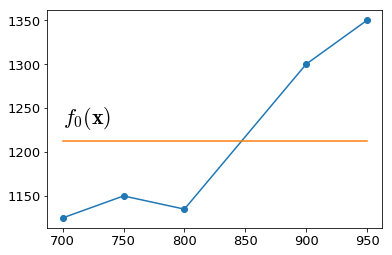

In [3]:
#rc('font',**{'family':'sans-serif'})
plt.plot(df.sqfeet,df.rent,'-o')
f0 = df.rent.mean()
print(f0)

plt.plot([df.sqfeet.min(),df.sqfeet.max()], [f0,f0])
plt.text(df.sqfeet.min(), f0+20, r"$f_0({\bf x})$",
        fontsize=22)
plt.show()

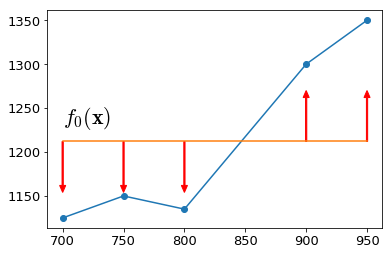

In [4]:
plt.plot(df.sqfeet,df.rent,'-o')
f0 = df.rent.mean()
plt.plot([df.sqfeet.min(),df.sqfeet.max()], [f0,f0])
plt.text(df.sqfeet.min(), f0+20, r"$f_0({\bf x})$",
         fontsize=22)
dir = np.sign(df.rent - f0) * 50
for x,y_hat in zip(df.sqfeet,dir):
    if y_hat!=0:
        plt.arrow(x, f0, 0, y_hat, fc='r', ec='r',
                  width=1.0,
                 head_width=5, head_length=8)
plt.show()

In [82]:
f0 = df.rent.mean()
print("rent mean", f0)
df['F0'] = f0
print("F0 MSE", mean_squared_error(df.rent, df.F0), "MAE", mean_absolute_error(df.rent, df.F0))

eta = 0.75
splits = [None,850, 850, 925, 725]

def stub_predict(x_train, y_train, split):
    left = y_train[x_train<split]
    right = y_train[x_train>split]
    lmean = np.mean(left)
    rmean = np.mean(right)    
    return [lmean if x<split else rmean for x in x_train]

df['dir1'] = df.rent - df.F0
df['delta1'] = stub_predict(df.sqfeet, df.dir1, splits[1])
df['F1'] = df.F0 + eta * df.delta1
print("F1 MSE", mean_squared_error(df.rent, df.F1), "MAE", mean_absolute_error(df.rent, df.F1))

df['dir2'] = df.rent - df.F1
df['delta2'] = stub_predict(df.sqfeet, df.dir2, splits[2])
df['F2'] = df.F1 + eta * df.delta2
print("F2 MSE", mean_squared_error(df.rent, df.F2), "MAE", mean_absolute_error(df.rent, df.F2))

df['dir3'] = df.rent - df.F2
df['delta3'] = stub_predict(df.sqfeet, df.dir3, splits[3])
df['F3'] = df.F2 + eta * df.delta3
print("F3 MSE", mean_squared_error(df.rent, df.F3), "MAE", mean_absolute_error(df.rent, df.F3))

df['dir4'] = df.rent - df.F3
df['delta4'] = stub_predict(df.sqfeet, df.dir4, splits[4])
df['F4'] = df.F3 + eta * df.delta4
print("F4 MSE", mean_squared_error(df.rent, df.F4), "MAE", mean_absolute_error(df.rent, df.F4))

df['dir5'] = df.rent - df.F4

df

rent mean 1212.0
F0 MSE 8826.0 MAE 90.4
F1 MSE 845.375 MAE 22.6
F2 MSE 346.5859375 MAE 16.275
F3 MSE 105.64752197265625 MAE 9.0609375
F4 MSE 80.47620987892151 MAE 7.5064453125


,sqfeet,rent,F0,dir1,delta1,F1,dir2,delta2,F2,dir3,delta3,F3,dir4,delta4,F4,dir5
0,700,1125,1212.0,-87.0,-75.333333,1155.50,-30.50,-18.833333,1141.3750,-16.3750,-8.015625,1135.363281,-10.363281,-10.363281,1127.590820,-2.590820
4,750,1150,1212.0,-62.0,-75.333333,1155.50,-5.50,-18.833333,1141.3750,8.6250,-8.015625,1135.363281,14.636719,2.590820,1137.306396,12.693604
2,800,1135,1212.0,-77.0,-75.333333,1155.50,-20.50,-18.833333,1141.3750,-6.3750,-8.015625,1135.363281,-0.363281,2.590820,1137.306396,-2.306396
3,900,1300,1212.0,88.0,113.000000,1296.75,3.25,28.250000,1317.9375,-17.9375,-8.015625,1311.925781,-11.925781,2.590820,1313.868896,-13.868896
1,950,1350,1212.0,138.0,113.000000,1296.75,53.25,28.250000,1317.9375,32.0625,32.062500,1341.984375,8.015625,2.590820,1343.927490,6.072510


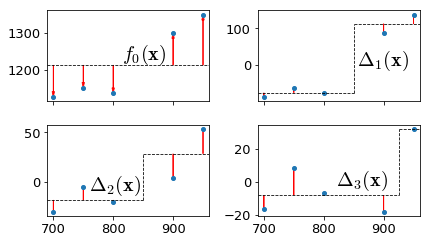

In [87]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 3.5), sharex=True)
plt.tight_layout()
axes[0][0].plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4)
axes[0][0].plot([df.sqfeet.min()-10,df.sqfeet.max()+10], [f0,f0],
         linewidth=.8, linestyle='--', c='k')
axes[0][0].set_xlim(df.sqfeet.min()-10,df.sqfeet.max()+10)
axes[0][0].text(815, f0+15, r"$f_0({\bf x})$", fontsize=20)
dir = np.sign(df.rent - f0) * 50
# draw arrows
for x,y,yhat in zip(df.sqfeet,df.rent,df.F0):
    if y-yhat!=0:
        axes[0][0].arrow(x, f0, 0, y-f0,
                  length_includes_head=True,
                  fc='r', ec='r',
                  linewidth=0.8,
                  head_width=4, head_length=15,
                 )

# show just direction vectors
axes[0][1].plot(df.sqfeet,df.dir1,'o', linewidth=.8, markersize=4)
# draw step function at split point
split = splits[1]
left = df.delta1[df.sqfeet<split]
right = df.delta1[df.sqfeet>split]
lmean = np.mean(left)
rmean = np.mean(right)
axes[0][1].plot([df.sqfeet.min()-10,split], [lmean,lmean],
         linewidth=.8, linestyle='--', c='k')
axes[0][1].plot([split,df.sqfeet.max()+10], [rmean,rmean],
         linewidth=.8, linestyle='--', c='k')
axes[0][1].plot([split,split], [lmean,rmean],
         linewidth=.8, linestyle='--', c='k')
axes[0][1].text(split+5, df.delta1.mean(), r"$\Delta_1({\bf x})$", fontsize=20)

# draw arrows
for x,y,yhat in zip(df.sqfeet,df.dir1,df.delta1):
    if y-yhat!=0:
        axes[0][1].arrow(x, yhat, 0, y-yhat,
                  length_includes_head=True,
                  fc='r', ec='r',
                  linewidth=0.8,
#                  head_width=4, head_length=15,
                 )

#
axes[1][0].plot(df.sqfeet,df.dir2,'o', linewidth=.8, markersize=4)
#
split = splits[2]
left = df.delta2[df.sqfeet<split]
right = df.delta2[df.sqfeet>split]
lmean = np.mean(left)
rmean = np.mean(right)
axes[1][0].plot([df.sqfeet.min()-10,split], [lmean,lmean],
         linewidth=.8, linestyle='--', c='k')
axes[1][0].plot([split,df.sqfeet.max()+10], [rmean,rmean],
         linewidth=.8, linestyle='--', c='k')
axes[1][0].plot([split,split], [lmean,rmean],
         linewidth=.8, linestyle='--', c='k')
axes[1][0].text(760, lmean+10, r"$\Delta_2({\bf x})$", fontsize=20)
# draw arrows
for x,y,yhat in zip(df.sqfeet,df.dir2,df.delta2):
    if y-yhat!=0:
        axes[1][0].arrow(x, yhat, 0, y-yhat,
                  length_includes_head=True,
                  fc='r', ec='r',
                  linewidth=0.8,
#                  head_width=2, head_length=8,
                 )

#
axes[1][1].plot(df.sqfeet,df.dir3,'o', linewidth=.8, markersize=4)
split = splits[3]
left = df.delta3[df.sqfeet<split]
right = df.delta3[df.sqfeet>split]
lmean = np.mean(left)
rmean = np.mean(right)
axes[1][1].plot([df.sqfeet.min()-10,split], [lmean,lmean],
         linewidth=.8, linestyle='--', c='k')
axes[1][1].plot([split,df.sqfeet.max()+10], [rmean,rmean],
         linewidth=.8, linestyle='--', c='k')
axes[1][1].plot([split,split], [lmean,rmean],
         linewidth=.8, linestyle='--', c='k')
axes[1][1].text(820, lmean+6, r"$\Delta_3({\bf x})$", fontsize=20)
# draw arrows
for x,y,yhat in zip(df.sqfeet,df.dir3,df.delta3):
    if y-yhat!=0:
        axes[1][1].arrow(x, yhat, 0, y-yhat,
                  length_includes_head=True,
                  fc='r', ec='r',
                  linewidth=0.8,
#                  head_width=2, head_length=8,
                 )

if False:
    axes[2][0].plot(df.sqfeet,df.dir4,'o', linewidth=.8, markersize=4)
    split = splits[4]
    left = df.delta4[df.sqfeet<split]
    right = df.delta4[df.sqfeet>split]
    lmean = np.mean(left)
    rmean = np.mean(right)
    axes[2][0].plot([df.sqfeet.min()-10,split], [lmean,lmean],
             linewidth=.8, linestyle='--', c='k')
    axes[2][0].plot([split,df.sqfeet.max()+10], [rmean,rmean],
             linewidth=.8, linestyle='--', c='k')
    axes[2][0].plot([split,split], [lmean,rmean],
             linewidth=.8, linestyle='--', c='k')
    axes[2][0].text(820, rmean+3.5, r"$\Delta_4({\bf x})$", fontsize=20)
    # draw arrows
    for x,y,yhat in zip(df.sqfeet,df.dir4,df.delta4):
        if y-yhat!=0:
            axes[2][0].arrow(x, yhat, 0, y-yhat,
                      length_includes_head=True,
                      fc='r', ec='r',
                      linewidth=0.8,
    #                  head_width=2, head_length=8,
                     )

    axes[2][1].plot(df.sqfeet,df.dir5,'o', linewidth=.8, markersize=4)

        
plt.savefig('/tmp/t.svg')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'scaled1'

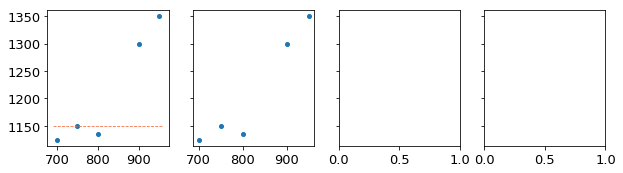

In [7]:
f0 = df.rent.median()

red = bookcolors['redorange']
blue = bookcolors['blue']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 2.5), sharey=True)
#plt.tight_layout()

#axes[0][0].plot(df.sqfeet,df.rent,'-o', linewidth=.8, markersize=4)

axes[0].plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4)
axes[0].plot([df.sqfeet.min()-10,df.sqfeet.max()+10], [f0,f0],
         linewidth=.8, linestyle='--', c=red)

# plt.xlim(df.sqfeet.min()-10,df.sqfeet.max()+10)
# plt.text(df.sqfeet.min()+5, f0+15, r"$f_0({\bf x})$",
#          fontsize=20)
axes[0].set
dir = np.sign(df.rent - f0) * 50
stage = 1
y_hat = np.array

axes[1].plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4)
axes[1].plot(df.sqfeet, f0+df.scaled1,
         linewidth=.8, linestyle='--', c=red)

axes[2].plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4)
axes[2].plot(df.sqfeet, f0+df.scaled1+df.scaled2,
         linewidth=.8, linestyle='--', c=red)

axes[3].plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4)
axes[3].plot(df.sqfeet, f0+df.scaled1+df.scaled2+df.scaled3,
         linewidth=.8, linestyle='--', c=blue)
#axes[0].text(700, 1325, r"$f_0({\bf x})$")
axes[0].set_title(r"$F_0({\bf x}) = f_0({\bf x})$", fontsize=18)
axes[1].set_title(r"$F_1({\bf x})$", fontsize=18)
axes[2].set_title(r"$F_2({\bf x})$", fontsize=18)
axes[3].set_title(r"$F_3({\bf x})$", fontsize=18)
plt.savefig('/tmp/t.svg')
plt.show()